In [1]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [2]:
# Step 2: Load Data
plant1 = pd.read_csv('/content/drive/MyDrive/Final_Merged_Plant_1.csv')
plant2 = pd.read_csv('/content/drive/MyDrive/Final_Merged_Plant_2.csv')

plant1['DATE_TIME'] = pd.to_datetime(plant1['DATE_TIME'])
plant2['DATE_TIME'] = pd.to_datetime(plant2['DATE_TIME'])

plant1['PLANT'] = 'Plant_1'
plant2['PLANT'] = 'Plant_2'

combined_df = pd.concat([plant1, plant2], ignore_index=True)
combined_df.dropna(inplace=True)

In [3]:
# Step 3: Exploratory Data Analysis (EDA)

# 3.1 Overview of the Dataset
print(combined_df.info())
print(combined_df.describe())

# 3.2 Missing Values Check
print(combined_df.isnull().sum())

# Print the first few columns (say, first 3 columns) for the first few rows
print(combined_df.iloc[:, :].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136472 entries, 0 to 136471
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DATE_TIME            136472 non-null  datetime64[ns]
 1   PLANT_ID             136472 non-null  int64         
 2   SOURCE_KEY           136472 non-null  object        
 3   DC_POWER             136472 non-null  float64       
 4   AC_POWER             136472 non-null  float64       
 5   DAILY_YIELD          136472 non-null  float64       
 6   TOTAL_YIELD          136472 non-null  float64       
 7   AMBIENT_TEMPERATURE  136472 non-null  float64       
 8   MODULE_TEMPERATURE   136472 non-null  float64       
 9   IRRADIATION          136472 non-null  float64       
 10  PLANT                136472 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 11.5+ MB
None
                           DATE_TIME      PLANT_

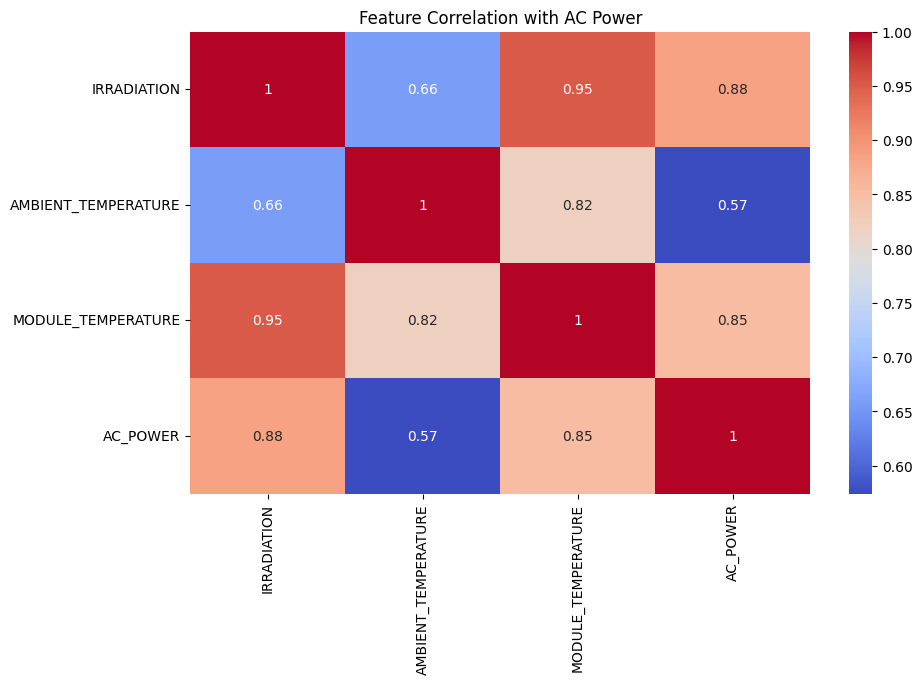

In [4]:
# 3.3 Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(combined_df[['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'AC_POWER']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation with AC Power')
plt.show()

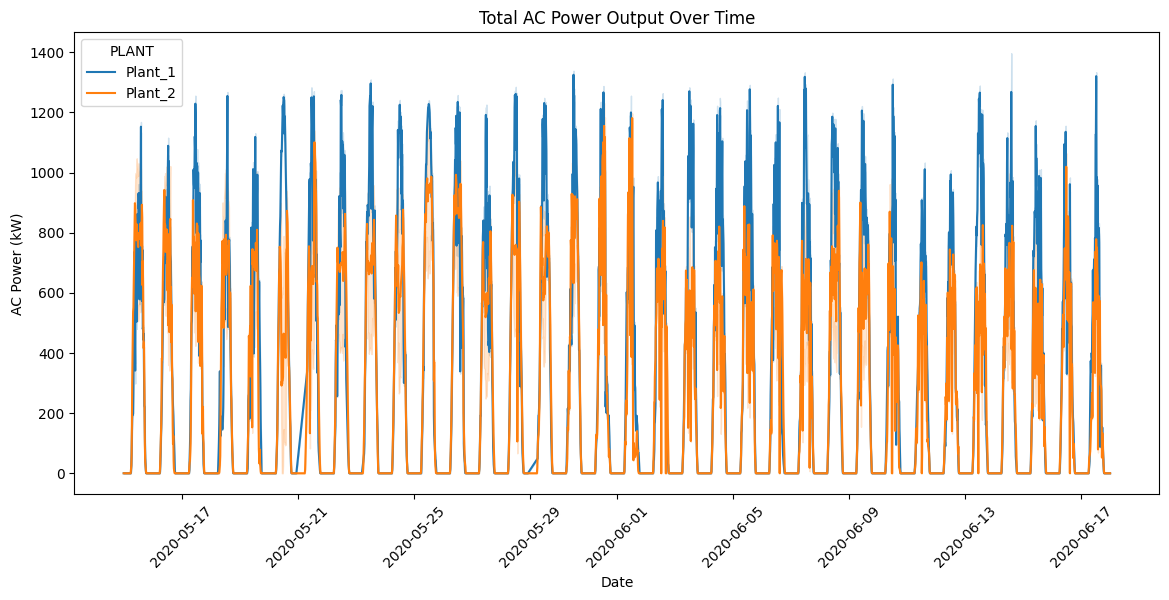

In [5]:
# 3.4 Total Power Output over Time
plt.figure(figsize=(14,6))
sns.lineplot(data=combined_df, x='DATE_TIME', y='AC_POWER', hue='PLANT')
plt.title('Total AC Power Output Over Time')
plt.xlabel('Date')
plt.ylabel('AC Power (kW)')
plt.xticks(rotation=45)
plt.show()

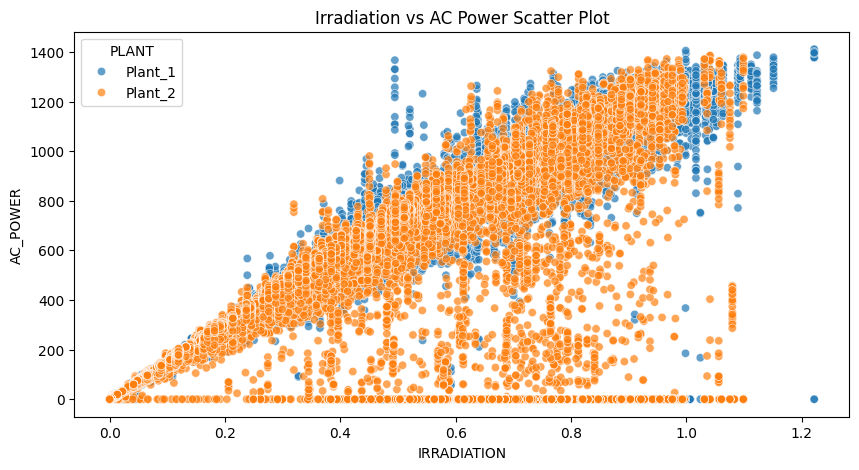

In [6]:
# 3.5 Scatter Plot: Irradiation vs AC Power
plt.figure(figsize=(10,5))
sns.scatterplot(data=combined_df, x='IRRADIATION', y='AC_POWER', hue='PLANT', alpha=0.7)
plt.title('Irradiation vs AC Power Scatter Plot')
plt.show()

In [7]:
# Step 4: Feature Selection and Scaling
features = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']
target = 'AC_POWER'

X = combined_df[features]
y = combined_df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Random Forest Classifier Performance:
Accuracy: 0.9552
Precision: 0.9577
Recall: 0.9552

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     13520
           1       0.84      0.88      0.86       125
           2       0.98      0.96      0.97      6841
           3       0.88      0.96      0.92      6809

    accuracy                           0.96     27295
   macro avg       0.92      0.94      0.93     27295
weighted avg       0.96      0.96      0.96     27295



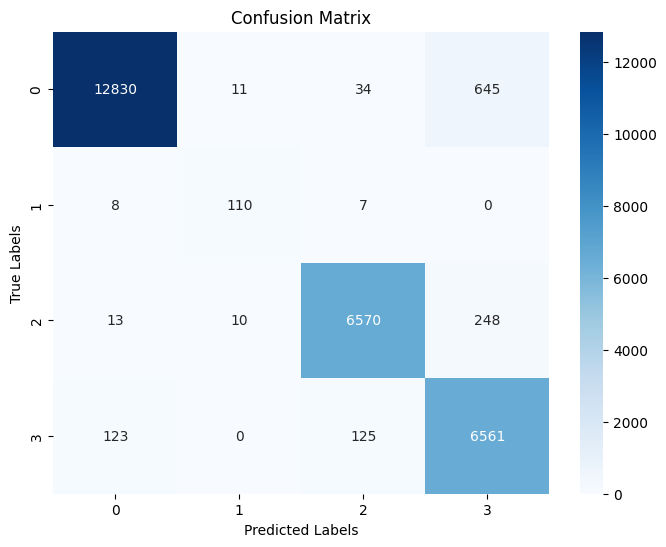

<ipython-input-9-c590c124ac70>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test_class, palette='Blues')
<ipython-input-9-c590c124ac70>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred_class, palette='Oranges')


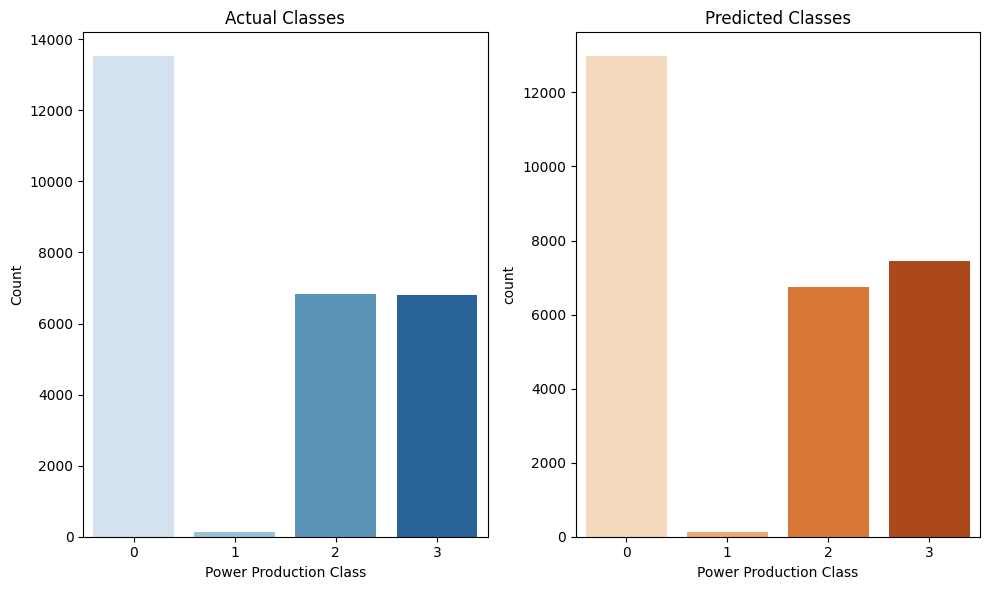

In [9]:
# Step 6: Random Forest Model
# Add to your existing imports for classification metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 6 Modified: Random Forest Classifier
# First, we need to convert the regression problem to classification
# Let's create categories for AC_POWER based on quartiles or another meaningful threshold

# Method 1: Using quartiles to create classes
q_25 = combined_df['AC_POWER'].quantile(0.25)
q_50 = combined_df['AC_POWER'].quantile(0.50)
q_75 = combined_df['AC_POWER'].quantile(0.75)

def categorize_power(power):
    if power <= q_25:
        return 0  # Low production
    elif power <= q_50:
        return 1  # Medium-low production
    elif power <= q_75:
        return 2  # Medium-high production
    else:
        return 3  # High production

# Apply the function to create categorical target
y_class = combined_df['AC_POWER'].apply(categorize_power)

# Alternative Method 2: Binary classification (if preferred)
# median = combined_df['AC_POWER'].median()
# y_class = (combined_df['AC_POWER'] > median).astype(int)  # 0: below median, 1: above median

# Split the data
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_scaled, y_class, test_size=0.2, random_state=42
)

# 6.1 Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_class, y_train_class)

# 6.2 Predict and Evaluate
y_pred_class = rf_classifier.predict(X_test_class)

# Calculate metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
# For multi-class, we use 'weighted' average
precision = precision_score(y_test_class, y_pred_class, average='weighted')
recall = recall_score(y_test_class, y_pred_class, average='weighted')

print("\nRandom Forest Classifier Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



# Actual vs Predicted Classes Comparison
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_test_class, palette='Blues')
plt.title('Actual Classes')
plt.xlabel('Power Production Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_pred_class, palette='Oranges')
plt.title('Predicted Classes')
plt.xlabel('Power Production Class')
plt.tight_layout()
plt.show()

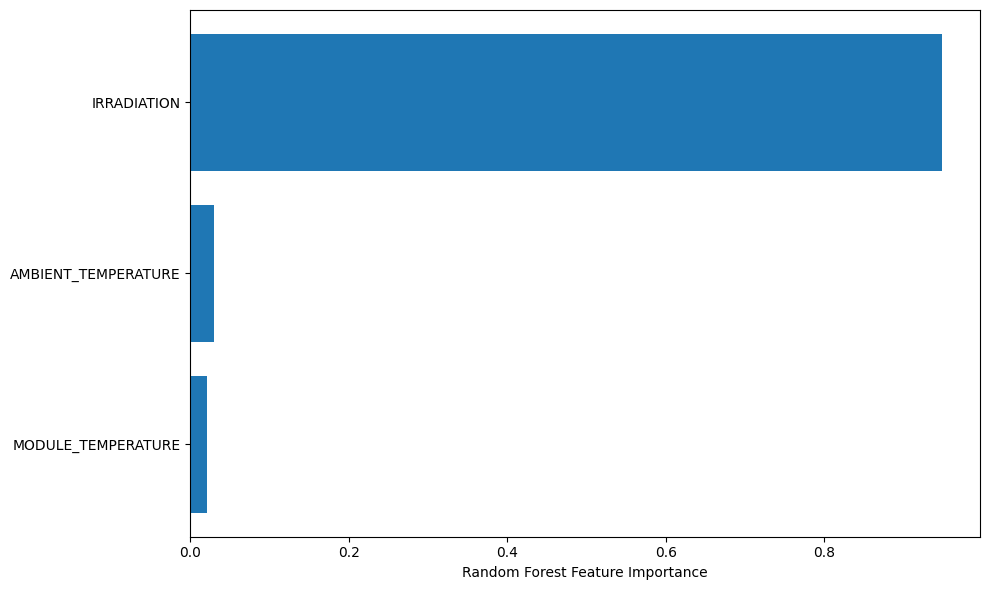

In [10]:
from sklearn.ensemble import RandomForestRegressor  # Changed to Regressor
import matplotlib.pyplot as plt

# Assuming X (features) and y (target) are already defined
# If not, load your data first

# Create and train the model (now using Regressor)
model = RandomForestRegressor()  # Changed to Regressor
model.fit(X, y)  # Now works for continuous y

# Get feature importances
importances = model.feature_importances_

# Get feature names (if X is a DataFrame)
if hasattr(X, 'columns'):
    features = X.columns.tolist()
else:
    features = [f'Feature {i}' for i in range(X.shape[1])]

# Plot feature importances
plt.figure(figsize=(10, 6))
sorted_idx = importances.argsort()
plt.barh(range(X.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), [features[i] for i in sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_scaled and y (AC_POWER) are already prepared from previous steps
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predictions
y_pred = rf_regressor.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Regressor Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

Random Forest Regressor Performance:
RMSE: 150.5683
R2 Score: 0.8436


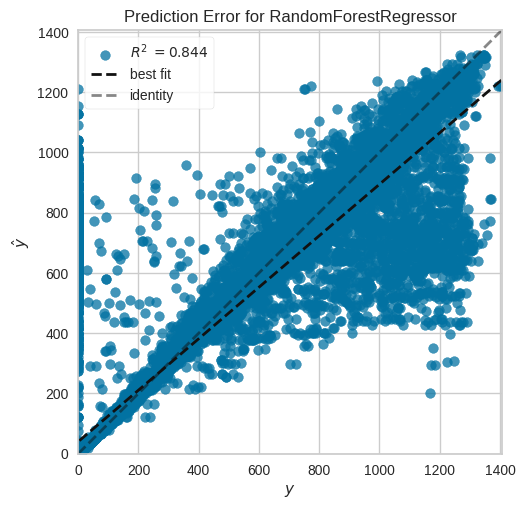

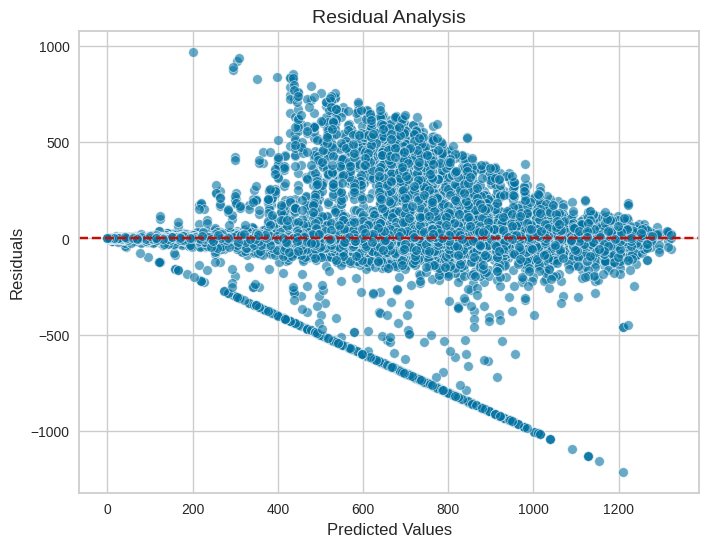

In [12]:
#Prediction Error Plot (Using Yellowbrick)
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(rf_regressor)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

#Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residual Analysis", fontsize=14)
plt.grid(True)
plt.show()

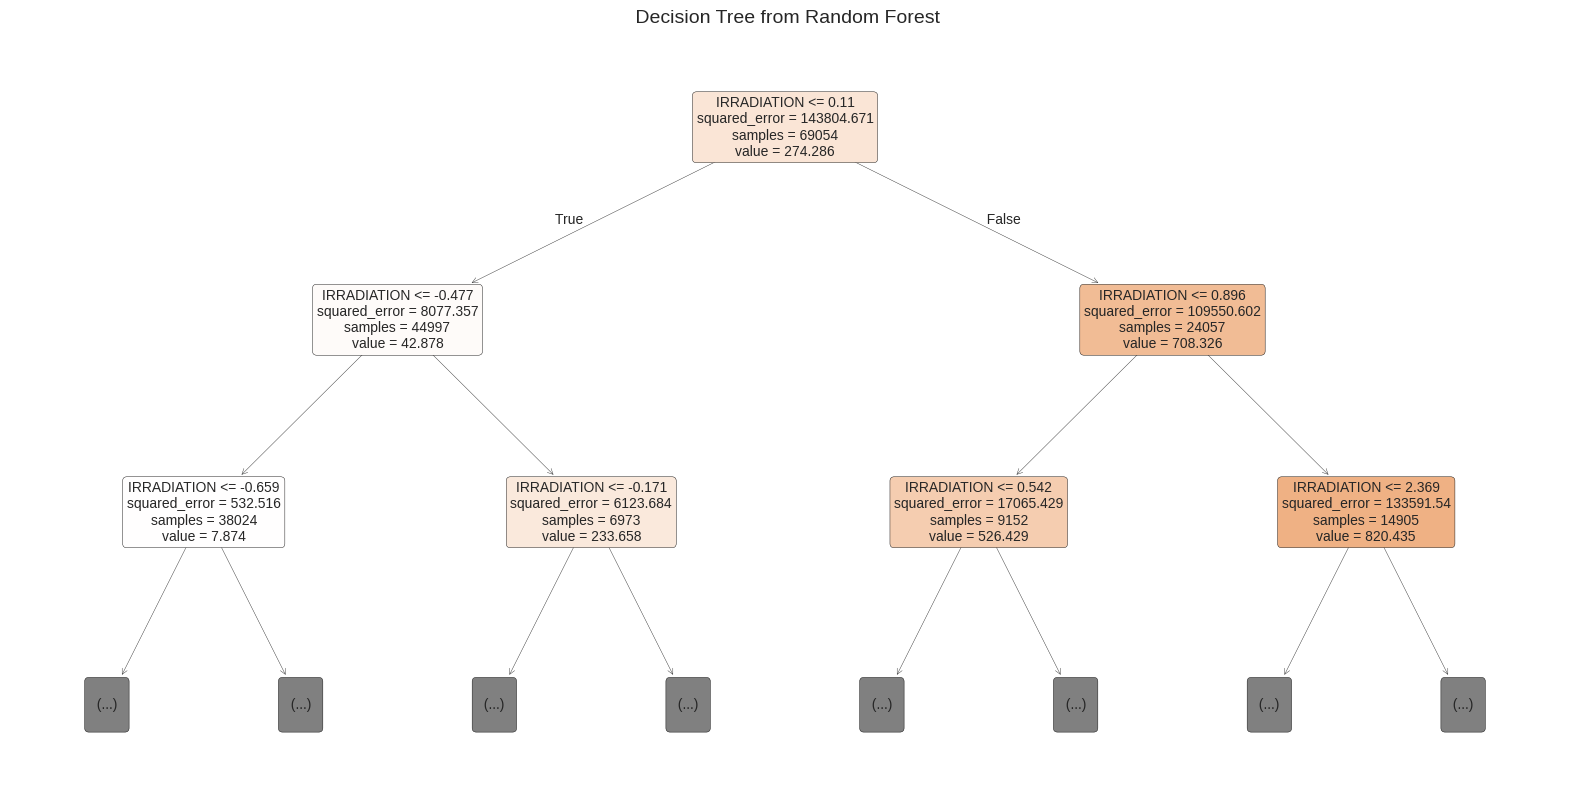

In [13]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    rf_regressor.estimators_[0],
    feature_names=X.columns,
    filled=True,
    rounded=True,
    max_depth=2,  # Limit depth for readability
    fontsize=10
)
plt.title(" Decision Tree from Random Forest", fontsize=14)
plt.show()

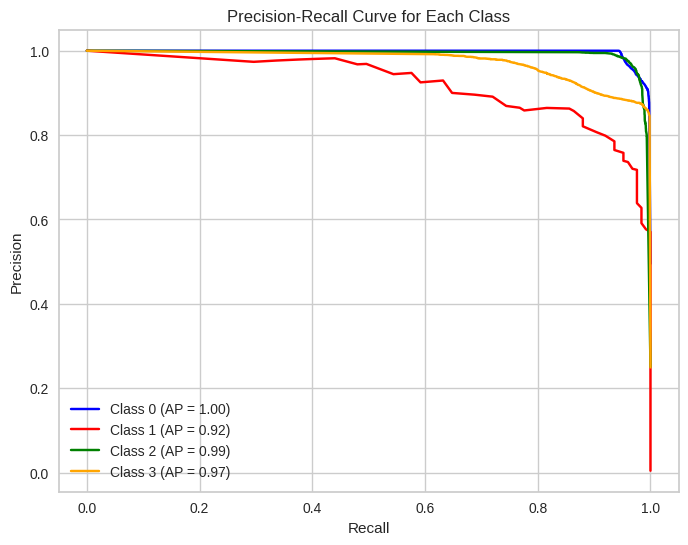

In [14]:
# Precision-Recall Curve (for multi-class)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# Binarize the output
y_test_bin = label_binarize(y_test_class, classes=[0, 1, 2, 3])
y_score = rf_classifier.predict_proba(X_test_class)

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(np.unique(y_class))):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                      y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Plot all precision-recall curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(len(np.unique(y_class))), colors):
    plt.plot(recall[i], precision[i], color=color,
             label='Class {0} (AP = {1:0.2f})'
             ''.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.title('Precision-Recall Curve for Each Class')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 47s 27ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 83s 27ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - loss: 0.0015 - val_loss: 0.0015


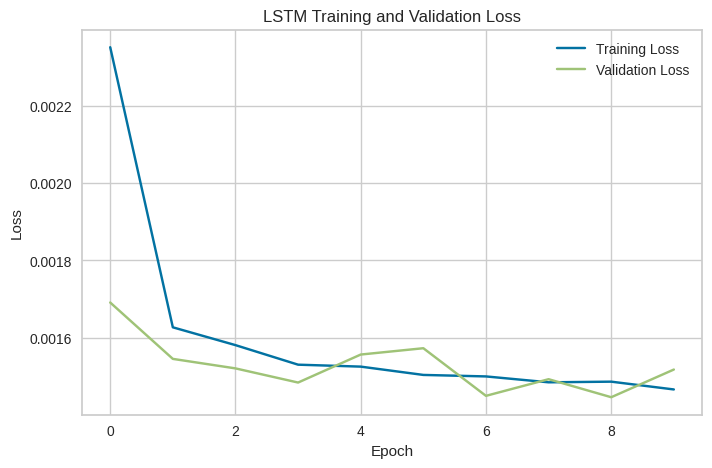

430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
LSTM Model Performance:
MAE: 21.67787608802989
RMSE: 54.96806566396554
R² Score: 0.9774402701603826


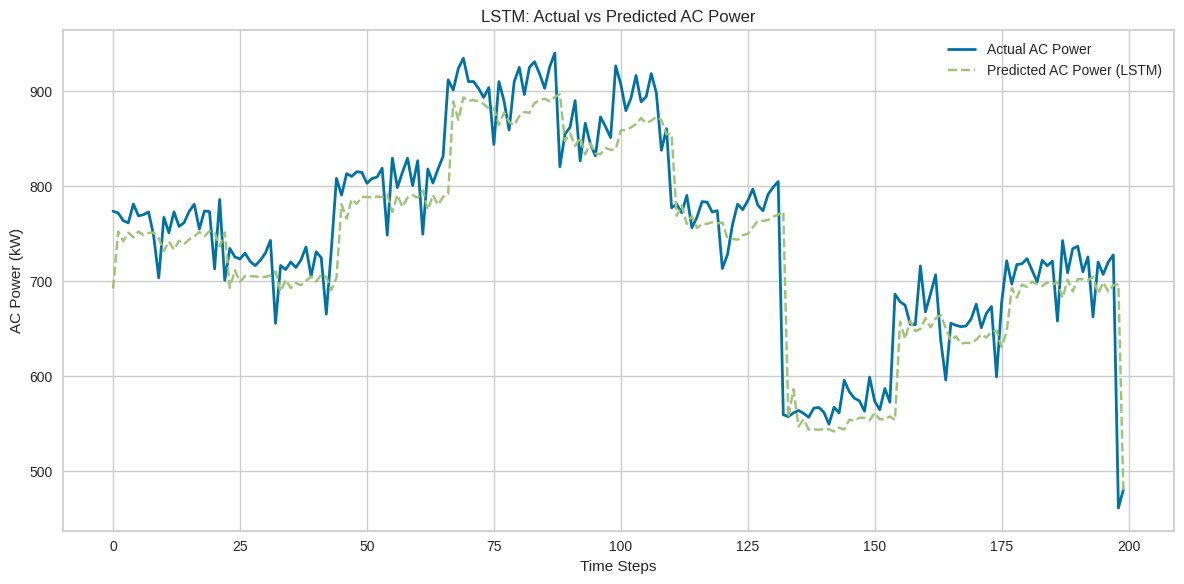

In [15]:
# Step 7: LSTM Model for Sequential Forecasting

# 7.1 Prepare Data for LSTM
lstm_df = plant1[['DATE_TIME', 'AC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']]
lstm_df = lstm_df.sort_values('DATE_TIME').dropna()

lstm_scaler = MinMaxScaler()
scaled_lstm_data = lstm_scaler.fit_transform(lstm_df.drop(columns='DATE_TIME'))

def create_sequences(data, sequence_length=24):
    X_seq, y_seq = [], []
    for i in range(len(data) - sequence_length):
        X_seq.append(data[i:i + sequence_length])
        y_seq.append(data[i + sequence_length][0])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 24
X_lstm, y_lstm = create_sequences(scaled_lstm_data, sequence_length)

split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

# 7.2 Build LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# 7.3 Train LSTM Model
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

# 7.4 Plot Training and Validation Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Step 8: LSTM Model Evaluation

# 8.1 Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Inverse scaling
y_pred_actual = lstm_scaler.inverse_transform(
    np.concatenate([y_pred_lstm, np.zeros((len(y_pred_lstm), scaled_lstm_data.shape[1]-1))], axis=1)
)[:, 0]

y_test_actual = lstm_scaler.inverse_transform(
    np.concatenate([y_test_lstm.reshape(-1, 1), np.zeros((len(y_test_lstm), scaled_lstm_data.shape[1]-1))], axis=1)
)[:, 0]

print("LSTM Model Performance:")
print("MAE:", mean_absolute_error(y_test_actual, y_pred_actual))
print("RMSE:", np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)))
print("R² Score:", r2_score(y_test_actual, y_pred_actual))


# Step 9: Plot LSTM Predictions vs Actual
plt.figure(figsize=(12,6))
plt.plot(y_test_actual[:200], label='Actual AC Power', linewidth=2)
plt.plot(y_pred_actual[:200], label='Predicted AC Power (LSTM)', linestyle='--')
plt.title('LSTM: Actual vs Predicted AC Power')
plt.xlabel('Time Steps')
plt.ylabel('AC Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()



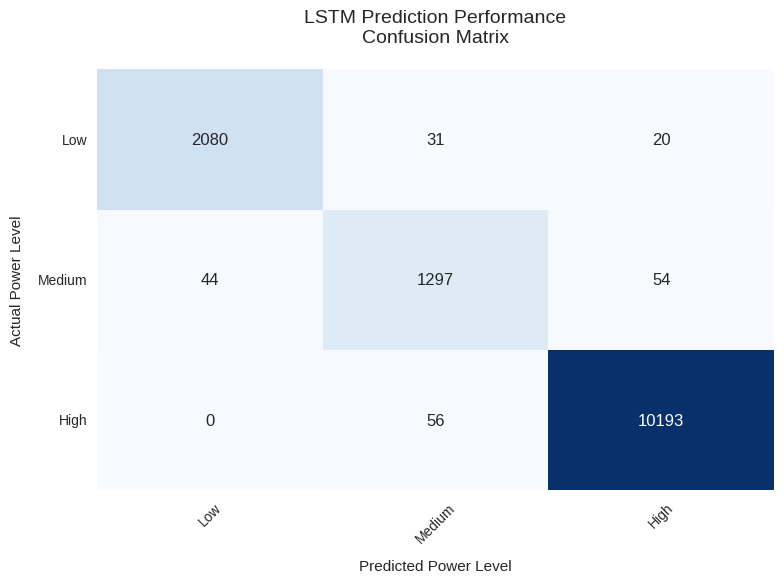


Classification Report:
              precision    recall  f1-score   support

         Low       0.99      0.99      0.99     10249
      Medium       0.98      0.98      0.98      2131
        High       0.94      0.93      0.93      1395

    accuracy                           0.99     13775
   macro avg       0.97      0.97      0.97     13775
weighted avg       0.99      0.99      0.99     13775



'\n# If your LSTM outputs classes directly (not regression):\n# Just use:\n# conf_matrix = confusion_matrix(y_test, y_pred)\n# print(classification_report(y_test, y_pred))\n'

In [16]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have:
# - y_test: True values (numpy array or pandas Series)
# - y_pred: LSTM predicted values (numpy array or pandas Series)

# ==============================================
# 1. DATA PREPARATION
# ==============================================

# Convert to pandas Series if they aren't already
y_test = pd.Series(y_test).reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True)

# If doing REGRESSION (continuous predictions) -> Discretize into classes
bins = [0, 100, 200, np.inf]  # Adjust these thresholds for your data
labels = ['Low', 'Medium', 'High']

# Convert to categorical bins (skip if already doing classification)
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)
y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels)

# Handle missing values - safer approach
valid_indices = y_test_binned.dropna().index.intersection(y_pred_binned.dropna().index)
y_test_final = y_test_binned.loc[valid_indices]
y_pred_final = y_pred_binned.loc[valid_indices]

# Convert to strings to avoid sorting issues
y_test_final = y_test_final.astype(str)
y_pred_final = y_pred_final.astype(str)

# ==============================================
# 2. CONFUSION MATRIX
# ==============================================

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_final, y_pred_final, labels=labels)

# Plot matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            cbar=False)
plt.title('LSTM Prediction Performance\nConfusion Matrix', pad=20, fontsize=14)
plt.xlabel('Predicted Power Level', labelpad=10)
plt.ylabel('Actual Power Level', labelpad=10)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ==============================================
# 3. CLASSIFICATION REPORT
# ==============================================

print("\nClassification Report:")
print("="*50)
print(classification_report(y_test_final, y_pred_final, target_names=labels))
print("="*50)

# ==============================================
# 4. ALTERNATIVE: IF ALREADY DOING CLASSIFICATION
# ==============================================
"""
# If your LSTM outputs classes directly (not regression):
# Just use:
# conf_matrix = confusion_matrix(y_test, y_pred)
# print(classification_report(y_test, y_pred))
"""

Training Random Forest Regressor...
Random Forest Regressor Performance:
MAE: 49.226546240661285
RMSE: 150.5683245234378
R² Score: 0.8436340539576612
Power classification thresholds: [np.float64(0.0), np.float64(3.493095238095238), np.float64(532.5685714250001)]

===== Random Forest Regressor Evaluation =====


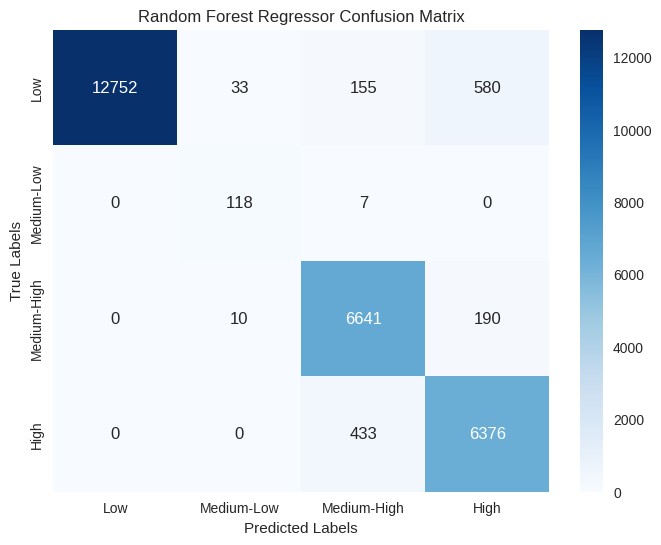

Accuracy: 0.9484
Precision: 0.9513
Recall: 0.9484

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     13520
           1       0.73      0.94      0.83       125
           2       0.92      0.97      0.94      6841
           3       0.89      0.94      0.91      6809

    accuracy                           0.95     27295
   macro avg       0.89      0.95      0.91     27295
weighted avg       0.95      0.95      0.95     27295



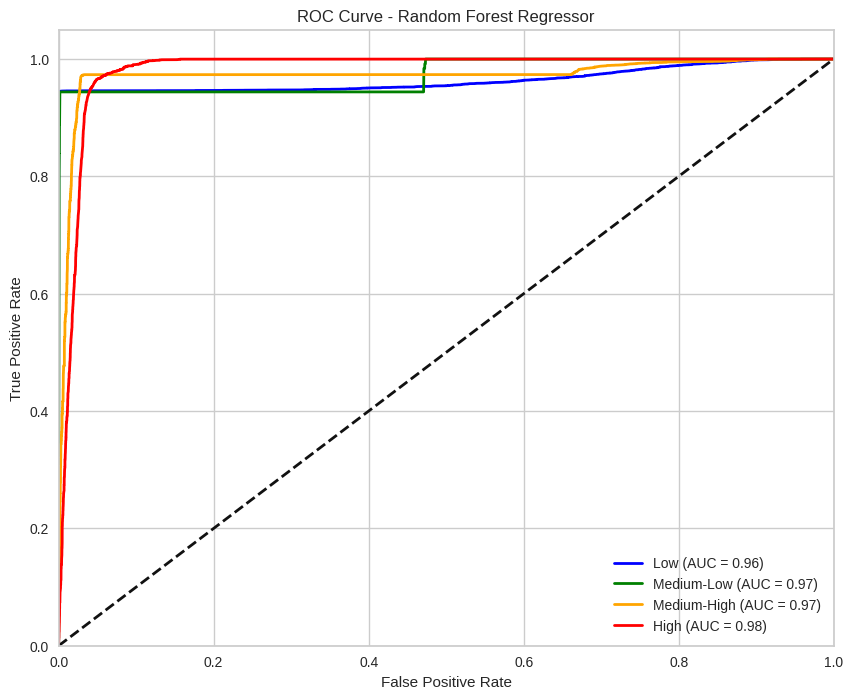


Training Random Forest Classifier...

===== Random Forest Classifier Evaluation =====


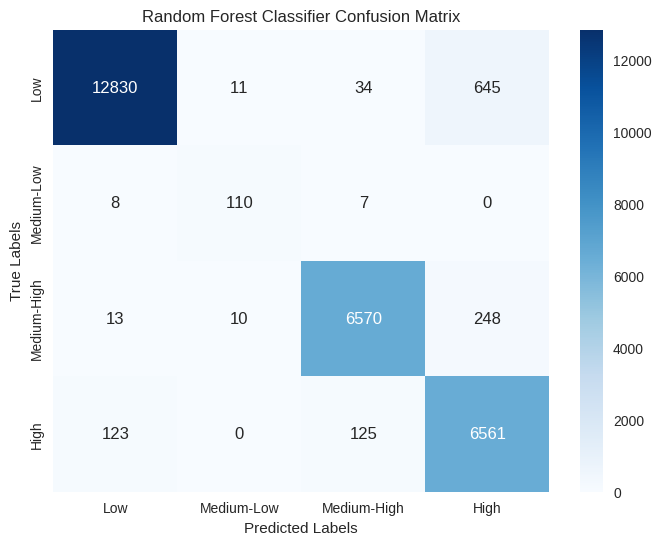

Accuracy: 0.9552
Precision: 0.9577
Recall: 0.9552

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     13520
           1       0.84      0.88      0.86       125
           2       0.98      0.96      0.97      6841
           3       0.88      0.96      0.92      6809

    accuracy                           0.96     27295
   macro avg       0.92      0.94      0.93     27295
weighted avg       0.96      0.96      0.96     27295



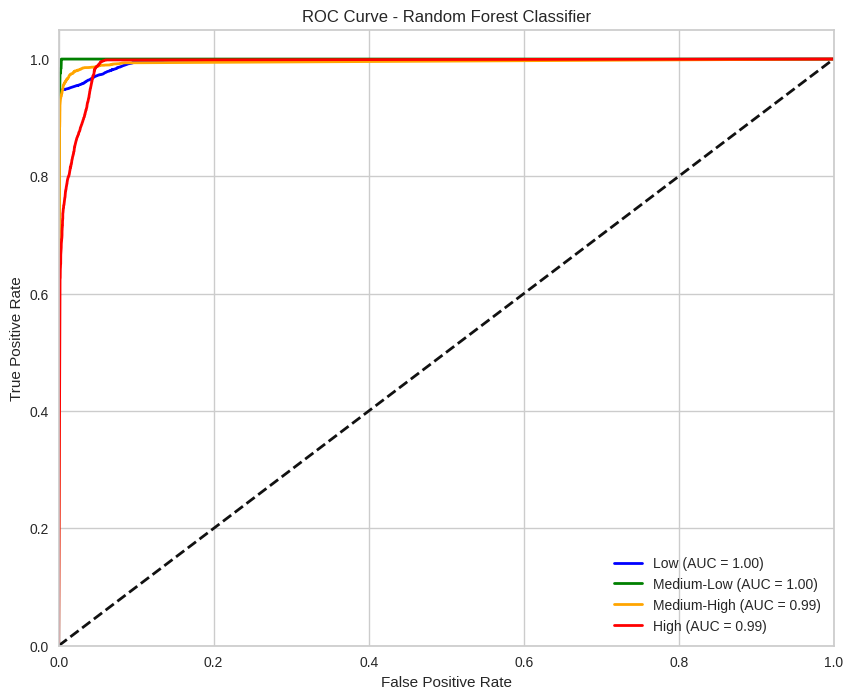

In [17]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Define features and target
features = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']
target = 'AC_POWER'

X = combined_df[features]
y = combined_df[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data for regression
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ========= Step 1: Train Random Forest Regressor =========
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("Random Forest Regressor Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R² Score:", r2_score(y_test, y_pred_rf))

# ========= Step 2: Create Classification Problem =========
# Calculate quartiles for discretization
thresholds = [
    combined_df['AC_POWER'].quantile(0.25),
    combined_df['AC_POWER'].quantile(0.50),
    combined_df['AC_POWER'].quantile(0.75)
]

print(f"Power classification thresholds: {thresholds}")

# Define function to categorize power values
def categorize_power(power, thresholds):
    for i, threshold in enumerate(thresholds):
        if power <= threshold:
            return i
    return len(thresholds)

# Create categorical target for classifier
y_class = np.array([categorize_power(val, thresholds) for val in combined_df[target]])

# Split data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_scaled, y_class, test_size=0.2, random_state=42
)

# Define function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    class_names = ['Low', 'Medium-Low', 'Medium-High', 'High']
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names)
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names)
    plt.show()
    return cm

# ========= Step 3: Evaluate Random Forest Regressor as Classifier =========
# Convert continuous predictions to classes for the Random Forest Regressor
y_test_reg_class = np.array([categorize_power(val, thresholds) for val in y_test])
y_pred_rf_class = np.array([categorize_power(val, thresholds) for val in y_pred_rf])

# Plot confusion matrix for Random Forest Regressor
print("\n===== Random Forest Regressor Evaluation =====")
cm_rf = plot_confusion_matrix(y_test_reg_class, y_pred_rf_class, 'Random Forest Regressor Confusion Matrix')

# Calculate classification metrics for regressor
accuracy_rf = accuracy_score(y_test_reg_class, y_pred_rf_class)
precision_rf = precision_score(y_test_reg_class, y_pred_rf_class, average='weighted')
recall_rf = recall_score(y_test_reg_class, y_pred_rf_class, average='weighted')

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_reg_class, y_pred_rf_class))

# For ROC curve - need to binarize for multi-class
n_classes = 4
y_test_bin = label_binarize(y_test_reg_class, classes=range(n_classes))

# Since Random Forest Regressor doesn't have predict_proba, we'll simulate probabilities
y_score_rf = np.zeros((len(y_pred_rf), n_classes))
for i in range(n_classes):
    lower = thresholds[i-1] if i > 0 else y_test.min()
    upper = thresholds[i] if i < len(thresholds) else y_test.max()
    midpoint = (lower + upper) / 2
    y_score_rf[:, i] = -np.abs(y_pred_rf - midpoint)  # Negative distance from class midpoint

# Normalize to [0,1]
mm_scaler = MinMaxScaler()
y_score_rf = mm_scaler.fit_transform(y_score_rf)

# Plot ROC curve for Random Forest Regressor
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
class_names = ['Low', 'Medium-Low', 'Medium-High', 'High']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Regressor')
plt.legend(loc="lower right")
plt.show()

# ========= Step 4: Train and Evaluate Random Forest Classifier =========
print("\nTraining Random Forest Classifier...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_class, y_train_class)
y_pred_class = rf_classifier.predict(X_test_class)

# Plot confusion matrix for Random Forest Classifier
print("\n===== Random Forest Classifier Evaluation =====")
cm_rfc = plot_confusion_matrix(y_test_class, y_pred_class, 'Random Forest Classifier Confusion Matrix')

# Calculate metrics for classifier
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, average='weighted')
recall = recall_score(y_test_class, y_pred_class, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))

# Plot ROC curve for Random Forest Classifier
y_score_rfc = rf_classifier.predict_proba(X_test_class)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_rfc[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()


===== Model Comparison =====
                      Model  Accuracy  Precision    Recall
0   Random Forest Regressor  0.948415   0.951288  0.948415
1  Random Forest Classifier  0.955157   0.957706  0.955157


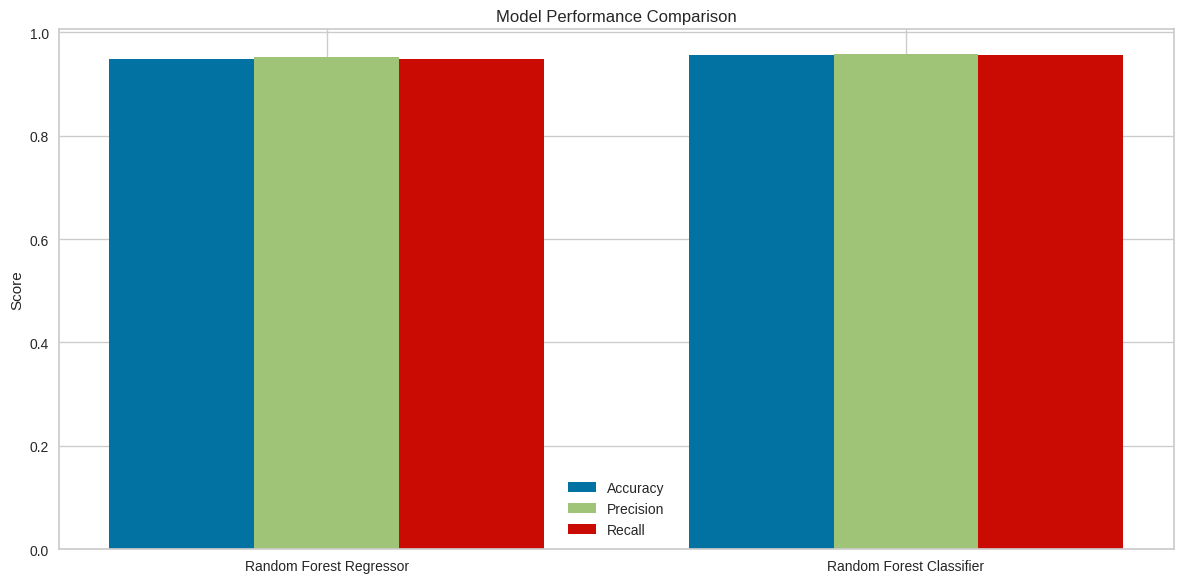

In [18]:
# ========= Step 5: Compare Models =========
# Create a summary table of metrics
models = ['Random Forest Regressor', 'Random Forest Classifier']
accuracies = [accuracy_rf, accuracy]
precisions = [precision_rf, precision]
recalls = [recall_rf, recall]

summary_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls
})

print("\n===== Model Comparison =====")
print(summary_df)

# Plot model comparison
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall']
x = np.arange(len(models))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, summary_df[metric], width, label=metric)

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width, models)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Assuming 'combined_df' is the dataframe after merging and initial cleaning
# Assuming 'TOTAL_YIELD' is the target variable based on your column list

# --- Added: Check DataFrame columns ---
print("Checking DataFrame columns before Feature Engineering:")
print(combined_df.columns)
# Please verify the exact name of your energy output column from the output above.
# If it's different from 'TOTAL_YIELD', replace 'TOTAL_YIELD' throughout the code
# with the correct column name (e.g., 'DC_POWER' or 'AC_POWER').
# -------------------------------------


# Step 4: Feature Engineering
print("\nStep 4: Feature Engineering")

# Verify that the target column exists before proceeding
# --- Updated: Changed default target_column to 'TOTAL_YIELD' ---
target_column = 'TOTAL_YIELD' # <--- Update this variable if the column name is different
# ------------------------------------------------------------------

if target_column not in combined_df.columns:
    print(f"Error: Target column '{target_column}' not found in the DataFrame.")
else:
    # Convert 'DATE_TIME' to datetime objects if not already done
    # Assuming 'DATE_TIME' column exists from previous steps
    if 'DATE_TIME' in combined_df.columns:
        combined_df['DATE_TIME'] = pd.to_datetime(combined_df['DATE_TIME'])
        # Set 'DATE_TIME' as index for easier time series operations
        combined_df.set_index('DATE_TIME', inplace=True)
    else:
        print("Warning: 'DATE_TIME' column not found. Skipping setting index.")
        # If DATE_TIME is missing, you might need to create a time index or handle differently
        # For this example, we'll assume DATE_TIME is crucial and exit or handle appropriately
        # For now, let's proceed assuming index is set or not needed for some features

    # Create time-based features (only if index is datetime-like or DATE_TIME exists)
    if isinstance(combined_df.index, pd.DatetimeIndex):
        combined_df['hour'] = combined_df.index.hour
        combined_df['dayofweek'] = combined_df.index.dayofweek
        combined_df['quarter'] = combined_df.index.quarter
        combined_df['month'] = combined_df.index.month
        combined_df['year'] = combined_df.index.year
        combined_df['dayofyear'] = combined_df.index.dayofyear
    else:
        print("Warning: Index is not DatetimeIndex. Skipping time-based feature creation.")


    # Create lag features for the target variable
    # Lag 1, 24 (previous hour, previous day) are common
    combined_df[f'{target_column}_lag1'] = combined_df[target_column].shift(1)
    combined_df[f'{target_column}_lag24'] = combined_df[target_column].shift(24)

    # Create rolling window features (e.g., mean of the last 24 hours)
    combined_df[f'{target_column}_rolling_mean24'] = combined_df[target_column].rolling(window=24).mean()

    # Drop rows with NaN values created by lagging/rolling
    combined_df.dropna(inplace=True)

    print(f"DataFrame shape after feature engineering and dropping NaNs: {combined_df.shape}")
    print(combined_df.head())


    # Step 5: Data Splitting
    print("\nStep 5: Data Splitting")

    # Define features (X) and target (y)
    # Exclude the original target variable and any intermediate columns used for feature creation if necessary
    # --- Updated: Exclude non-numeric columns like PLANT_ID, SOURCE_KEY, PLANT ---
    non_numeric_cols = ['PLANT_ID', 'SOURCE_KEY', 'PLANT'] # Add any other non-numeric columns here
    features = [col for col in combined_df.columns if col not in [target_column] + non_numeric_cols]
    # -----------------------------------------------------------------------------
    X = combined_df[features]
    y = combined_df[target_column]

    # Split data into training and testing sets
    # Using an 80/20 split, but you can adjust this
    # For time series, it's often better to split chronologically
    # Let's split based on index (time)
    train_size = int(len(combined_df) * 0.8)
    train_df, test_df = combined_df.iloc[:train_size], combined_df.iloc[train_size:]

    X_train, y_train = train_df[features], train_df[target_column]
    X_test, y_test = test_df[features], test_df[target_column]

    print(f"Training set shape (X_train, y_train): {X_train.shape}, {y_train.shape}")
    print(f"Testing set shape (X_test, y_test): {X_test.shape}, {y_test.shape}")


    # Step 6: Data Scaling
    print("\nStep 6: Data Scaling")

    # Initialize scalers
    # It's good practice to scale features and the target variable separately,
    # especially if you need to inverse transform the predictions later.
    feature_scaler = MinMaxScaler() # MinMaxScaler often works well for features with varying ranges
    target_scaler = MinMaxScaler() # Scale target for LSTM, optional for RF

    # Fit and transform on training data
    X_train_scaled = feature_scaler.fit_transform(X_train)
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)) # Reshape for scaler

    # Transform test data using the same fitted scalers
    X_test_scaled = feature_scaler.transform(X_test)
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)) # Reshape for scaler

    print("Data scaled successfully.")




Checking DataFrame columns before Feature Engineering:
Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER',
       'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE',
       'MODULE_TEMPERATURE', 'IRRADIATION', 'PLANT'],
      dtype='object')

Step 4: Feature Engineering
DataFrame shape after feature engineering and dropping NaNs: (136448, 19)
                     PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
DATE_TIME                                                            
2020-05-15 00:15:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
2020-05-15 00:15:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   
2020-05-15 00:15:00   4135001  VHMLBKoKgIrUVDU       0.0       0.0   
2020-05-15 00:15:00   4135001  WRmjgnKYAwPKWDb       0.0       0.0   
2020-05-15 00:15:00   4135001  ZnxXDlPa8U1GXgE       0.0       0.0   

                     DAILY_YIELD  TOTAL_YIELD  AMBIENT_TEMPERATURE  \
DATE_TIME                                                            
2020-